In [1]:
import pandas as pd
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import requests
import plotly.express as px
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: f'%.{2}f' % x)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('../8Jul2020-14Jul2020.csv')
cluster = df[['StartStation Name', 'StartStation lat', 'StartStation long']]
cluster.drop_duplicates(keep='first', inplace=True)
cluster.head()

C:\Users\rahin\AppData\Local\Temp\ipykernel_26696\1014782310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.drop_duplicates(keep='first', inplace=True)


,StartStation Name,StartStation lat,StartStation long
0,"Jubilee Plaza, Canary Wharf",51.50,-0.02
1,"Ford Road, Old Ford",51.53,-0.03
2,"Houndsditch, Aldgate",51.51,-0.08
4,"Ossulston Street, Somers Town",51.53,-0.13
6,"Endsleigh Gardens, Euston",51.53,-0.13


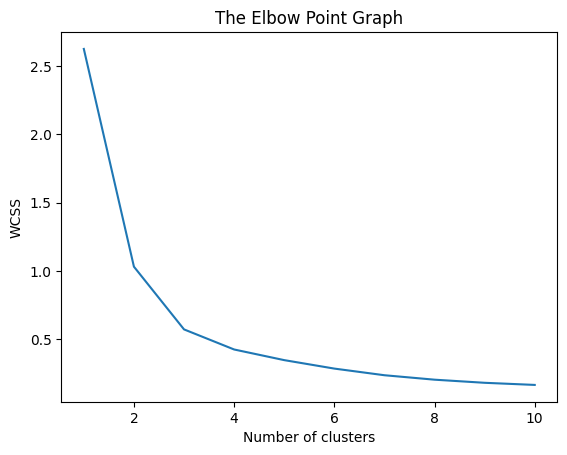

In [3]:
X = cluster[['StartStation lat', 'StartStation long']].values
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    #appending the WCSS to the list (kmeans.inertia_ returns the WCSS value for an initialized cluster)
    wcss.append(kmeans.inertia_)

#Plotting The Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [4]:
n_clusters_ = 3
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

In [5]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 
print((centers))

[[ 5.14923336e+01 -1.89484197e-01]
 [ 5.15194414e+01 -5.02181274e-02]
 [ 5.15089466e+01 -1.22637885e-01]]


In [6]:
# map each station with its region
cluster['clusters'] = labels
cluster.index = cluster['StartStation Name']
cluster_map = cluster['clusters'].to_dict()

df['cluster'] = df['StartStation Name'].map(cluster_map)
df.head()

C:\Users\rahin\AppData\Local\Temp\ipykernel_26696\3448031555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['clusters'] = labels


,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,EndStation lat,EndStation long,EndStation nbBikes,EndStation nbStandardBikes,EndStation nbEBikes,EndStation nbEmptyDocks,EndStation nbDocks,StartStation lat,StartStation long,StartStation nbBikes,StartStation nbStandardBikes,StartStation nbEBikes,StartStation nbEmptyDocks,StartStation nbDocks,cluster
0,99188805,780,13656,08/07/2020 00:13,476,"Stebondale Street, Cubitt Town",08/07/2020 00:00,532,"Jubilee Plaza, Canary Wharf",51.49,-0.01,26,24,2,3,29,51.50,-0.02,46,45,1,17,63,1
1,99188806,180,4393,08/07/2020 00:03,531,"Twig Folly Bridge, Mile End",08/07/2020 00:00,517,"Ford Road, Old Ford",51.53,-0.04,6,6,0,15,21,51.53,-0.03,2,2,0,16,18,1
2,99188809,960,8973,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,1
3,99188810,960,7141,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,1
4,99188807,600,15085,08/07/2020 00:11,201,"Dorset Square, Marylebone",08/07/2020 00:01,797,"Ossulston Street, Somers Town",51.52,-0.16,15,15,0,1,16,51.53,-0.13,28,27,1,2,30,2


(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
(0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)
(0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)


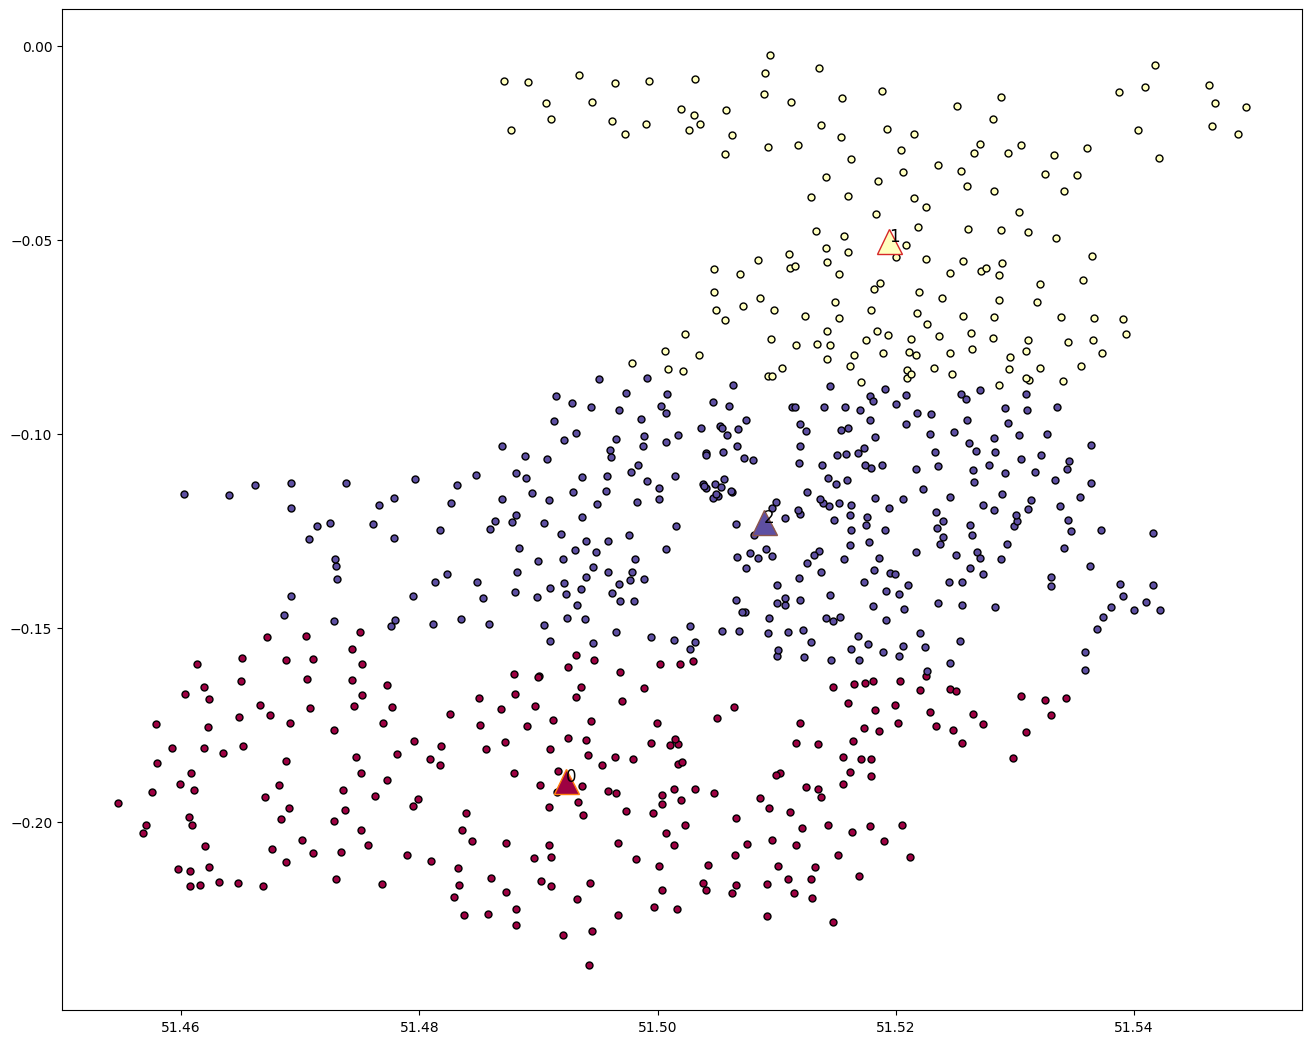

In [7]:
plt.rcParams['figure.figsize'] = [16,13]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
# BBox = (-79.4900,-79.2700,43.6100,43.7200)
#map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    print(tuple(col))

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12) 
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

In [8]:
df['Date'] = pd.to_datetime(df['Start Date'], dayfirst=True)
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.date
df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,EndStation lat,EndStation long,EndStation nbBikes,EndStation nbStandardBikes,EndStation nbEBikes,EndStation nbEmptyDocks,EndStation nbDocks,StartStation lat,StartStation long,StartStation nbBikes,StartStation nbStandardBikes,StartStation nbEBikes,StartStation nbEmptyDocks,StartStation nbDocks,cluster,Date
0,99188805,780,13656,08/07/2020 00:13,476,"Stebondale Street, Cubitt Town",08/07/2020 00:00,532,"Jubilee Plaza, Canary Wharf",51.49,-0.01,26,24,2,3,29,51.50,-0.02,46,45,1,17,63,1,2020-07-08
1,99188806,180,4393,08/07/2020 00:03,531,"Twig Folly Bridge, Mile End",08/07/2020 00:00,517,"Ford Road, Old Ford",51.53,-0.04,6,6,0,15,21,51.53,-0.03,2,2,0,16,18,1,2020-07-08
2,99188809,960,8973,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,1,2020-07-08
3,99188810,960,7141,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,1,2020-07-08
4,99188807,600,15085,08/07/2020 00:11,201,"Dorset Square, Marylebone",08/07/2020 00:01,797,"Ossulston Street, Somers Town",51.52,-0.16,15,15,0,1,16,51.53,-0.13,28,27,1,2,30,2,2020-07-08


In [9]:
temp = df.groupby(['Date', 'EndStation Name'])['EndStation nbBikes'].agg(['first', 'last']).diff(axis=1)
temp.reset_index(drop=False, inplace=True)

temp.drop(['first'], inplace=True, axis=1)
temp.rename(columns = {'last':'Diff'}, inplace = True)
temp.head()

,Date,EndStation Name,Diff
0,2020-07-08,"Abbey Orchard Street, Westminster",0
1,2020-07-08,"Abbotsbury Road, Holland Park",0
2,2020-07-08,"Aberdeen Place, St. John's Wood",0
3,2020-07-08,"Aberfeldy Street, Poplar",0
4,2020-07-08,"Abingdon Green, Westminster",0


In [10]:
temp.describe()

,Diff
count,5342.00
mean,0.00
std,0.00
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,0.00


In [11]:
temp = df.groupby(['Date', 'StartStation Name'])['Start Date','StartStation nbBikes'].agg(['first', 'last'])
temp.reset_index(drop=False, inplace=True)
temp.head()

C:\Users\rahin\AppData\Local\Temp\ipykernel_26696\478296273.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = df.groupby(['Date', 'StartStation Name'])['Start Date','StartStation nbBikes'].agg(['first', 'last'])


Date                  StartStation Name        Start Date  \
                                                             first   
0  2020-07-08  Abbey Orchard Street, Westminster  08/07/2020 06:56   
1  2020-07-08      Abbotsbury Road, Holland Park  08/07/2020 11:01   
2  2020-07-08    Aberdeen Place, St. John's Wood  08/07/2020 05:59   
3  2020-07-08           Aberfeldy Street, Poplar  08/07/2020 09:03   
4  2020-07-08        Abingdon Green, Westminster  08/07/2020 08:21   

                    StartStation nbBikes       
               last                first last  
0  08/07/2020 21:32                   15   15  
1  08/07/2020 19:36                    8    8  
2  08/07/2020 18:49                    1    1  
3  08/07/2020 19:31                   12   12  
4  08/07/2020 23:55                   14   14

In [12]:
temp[temp['StartStation Name'] == 'Shoreditch High Street, Shoreditch']

Date                   StartStation Name        Start Date  \
                                                                 first   
591   2020-07-08  Shoreditch High Street, Shoreditch  08/07/2020 09:34   
1353  2020-07-09  Shoreditch High Street, Shoreditch  09/07/2020 01:00   
2116  2020-07-10  Shoreditch High Street, Shoreditch  10/07/2020 02:14   
2880  2020-07-11  Shoreditch High Street, Shoreditch  11/07/2020 00:00   
3644  2020-07-12  Shoreditch High Street, Shoreditch  12/07/2020 00:10   
4408  2020-07-13  Shoreditch High Street, Shoreditch  13/07/2020 00:22   
5171  2020-07-14  Shoreditch High Street, Shoreditch  14/07/2020 02:30   

                       StartStation nbBikes       
                  last                first last  
591   08/07/2020 23:46                   24   24  
1353  09/07/2020 23:34                   24   24  
2116  10/07/2020 23:19                   24   24  
2880  11/07/2020 23:57                   24   24  
3644  12/07/2020 23:30                   24   24  
4408  13/07/2020 23:57                   24   24  
5171  14/07/2020 23:16                   24   24

In [13]:
temp = df.groupby(['EndStation Name'])['EndStation nbBikes'].agg(['first', 'last']).diff(axis=1)
temp.reset_index(drop=False, inplace=True)

temp.drop(['first'], inplace=True, axis=1)
temp.rename(columns = {'last':'Diff'}, inplace = True)
temp.describe()

,Diff
count,764.00
mean,0.00
std,0.00
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,0.00
